In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim

img = cv2.imread("pic.jpg")
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

In [2]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

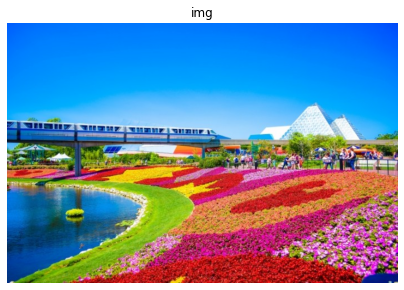

In [3]:
draw_picture(img, "img")

In [4]:
bl, gr, rd = cv2.split(img)

In [5]:
# складываем в одномерный массв троек
i_r = img.reshape((700*466, 3))

In [6]:
# восстанавливаем в рисунок
i_r_r = i_r.reshape((466,700, 3))

In [7]:
type(i_r[0][0])

numpy.uint8

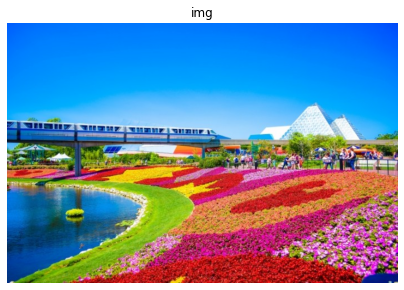

In [8]:
draw_picture(i_r_r, "img")

In [9]:
len(img[0])

700

In [10]:
# Исходное число цветов
df_test = pd.DataFrame(i_r,dtype=np.short)
df_test.drop_duplicates(inplace = True, ignore_index=True)
df_test

,0,1,2
0,255,92,0
1,253,93,0
2,254,94,0
3,255,96,0
4,253,96,0
...,...,...,...
164126,159,203,196
164127,166,207,200
164128,172,213,205
164129,175,213,201


In [11]:
# db = DBSCAN(eps=1, min_samples=100).fit(i_r)
# число кластеров
# df_dbscan = pd.DataFrame(i_r[db.core_sample_indices_])
# print(len(df_dbscan.drop_duplicates()))
# число "шумовых"
# print(len(db.labels_[np.where(db.labels_ == -1)]))

array([[[ 50, 158, 136],
        [ 21, 175, 128],
        [254, 130,   0],
        ...,
        [253, 164,   0],
        [254, 106,   0],
        [195, 144, 118]],

       [[252, 203, 135],
        [224, 170,  85],
        [254, 160,   0],
        ...,
        [114,  58, 193],
        [236, 146, 235],
        [253, 152,   0]],

       [[207, 114,  45],
        [163,  34,   0],
        [253, 144,   0],
        ...,
        [254, 112,   1],
        [254, 169,   0],
        [ 88,  72,  36]],

       ...,

       [[253, 201, 130],
        [  4,  36,  65],
        [ 99, 100, 161],
        ...,
        [253, 205, 141],
        [250, 207, 156],
        [255, 180,  58]],

       [[143, 202, 188],
        [113,  77,   7],
        [ 12,   0, 116],
        ...,
        [254, 136,   0],
        [ 16, 191, 127],
        [206, 147, 222]],

       [[ 11, 151, 127],
        [253, 180,  66],
        [254, 142,   0],
        ...,
        [252, 174,   8],
        [ 46,  38, 198],
        [  9,  12, 171]]

In [12]:
# # # https://github.com/scikit-learn/scikit-learn/issues/17960
# https://datascience.stackexchange.com/questions/47889/how-to-run-agglomerativeclustering-on-a-big-data-in-python

clustering = AgglomerativeClustering(linkage="single", n_clusters=10) # только на single и работает и то на малых данных
df_agl = pd.DataFrame(i_r.copy()).sample(n = 46*70) 
clustering.fit(df_agl)
# df_agl.to_numpy().reshape((46,70, 3))

ssim_agl = ssim(a.reshape((466,700, 3)), df.to_numpy().reshape((466,700, 3)), data_range=a.max() - a.min(),
            channel_axis=2 )
        # draw_picture(img, "img")
        draw_picture(df.to_numpy().reshape((466,700, 3)), "%s n_clust=%d ssim=%.02f" % (
            res[i]['alg'],
            res[i]['num_clusters'],
            res[i]['ssim'],

AgglomerativeClustering(linkage='single', n_clusters=10)

In [19]:
setup = [
{
    'alg':'KMeans',    'n_clusters':2,},
{
    'alg':'KMeans',    'n_clusters':5,},
{
    'alg':'KMeans',    'n_clusters':10,},
{
    'alg':'KMeans',    'n_clusters':20,},
{
    # не работает на больших эпсилон, т.к. считает матрицу расстояний (кривая реализация в scikit-learn) и падает по памяти
    'alg':'DBSCAN',    'eps':1,   'min_samples':100}, 
# {
#     'alg':'AgglomerativeClustering',    'n_clusters':2,},
# {
#     'alg':'AgglomerativeClustering',    'n_clusters':5,},
# {
#     'alg':'AgglomerativeClustering',    'n_clusters':10,},
# {
#     'alg':'AgglomerativeClustering',    'n_clusters':20,},
]

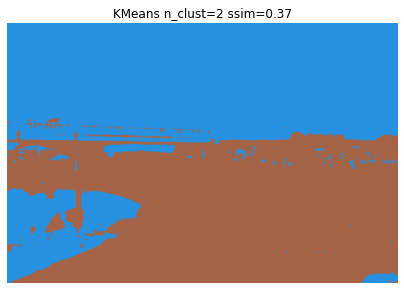

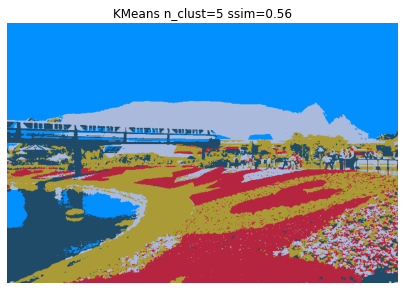

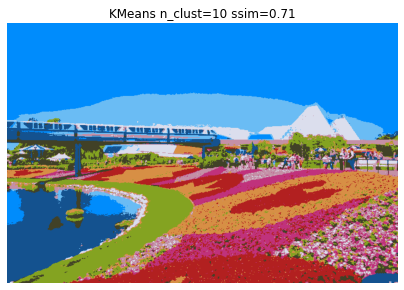

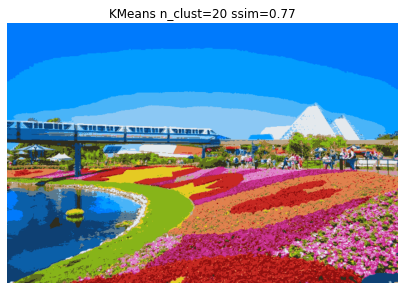

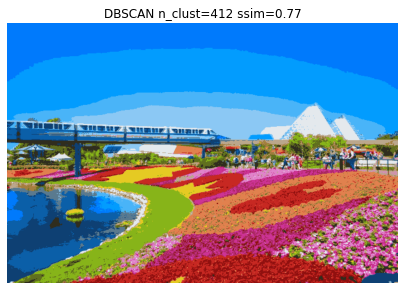

[{'alg': 'KMeans',
  'n_clusters': 2,
  'num_clusters': 2,
  'ssim': 0.3658969118486775},
 {'alg': 'KMeans',
  'n_clusters': 5,
  'num_clusters': 5,
  'ssim': 0.5578527273369912},
 {'alg': 'KMeans',
  'n_clusters': 10,
  'num_clusters': 10,
  'ssim': 0.7072902995860311},
 {'alg': 'KMeans',
  'n_clusters': 20,
  'num_clusters': 20,
  'ssim': 0.770452282098652},
 {'alg': 'DBSCAN',
  'eps': 1,
  'min_samples': 100,
  'num_clusters': 412,
  'ssim': 0.770452282098652}]

In [20]:
def run(stp,data):
    res = stp.copy()
    for i,d in enumerate(stp):
        # cluster
        # print('alg: %s' % (d['alg']))
        if d['alg']=='KMeans':
            kmeans = KMeans(n_clusters=d['n_clusters'], random_state=0).fit(data)
            res[i]['num_clusters'] = d['n_clusters']
        if d['alg']=='DBSCAN':
            db = DBSCAN(eps=d['eps'], min_samples=d['min_samples']).fit(data)
            df_dbscan = pd.DataFrame(data[db.core_sample_indices_])
            # число кластеров
            # print(len(df_dbscan.drop_duplicates()))
            # число "шумовых"
            # print(len(db.labels_[np.where(db.labels_ == -1)]))
            res[i]['num_clusters'] = len(df_dbscan.drop_duplicates())
        if d['alg']=='AgglomerativeClustering':
            agl = AgglomerativeClustering(linkage="single", n_clusters=d['n_clusters']).fit(data)
            res[i]['num_clusters'] = agl.n_clusters_
        # img_f = img_as_float(data.copy())
        # складываем в одномерный массв троек
        a = data.copy()
        # kmeans = KMeans(n_clusters=5, random_state=0).fit(i_r)
        # len(kmeans.cluster_centers_)
        df = pd.DataFrame(data.copy())
        # a = i_r
        # print(kmeans.cluster_centers_)
        
        # calc SSIM
        for idx, cntr in enumerate(kmeans.cluster_centers_): 
            # a0 = cntr
            cntr_idx = np.sum(np.square(np.abs(a-cntr)),1).argmin()
            cntr_color = a[cntr_idx]
            # print('cntr = %s' % (str(cntr)))
            # print('cntr_idx = %s' % (str(cntr_idx)))
            # print('color = %s' % (str(cntr_color)))
            df.loc[kmeans.labels_== idx, :] = cntr_color
            # print(len(df.loc[kmeans.labels_== idx, :]))
        res[i]['ssim'] = ssim(a.reshape((466,700, 3)), df.to_numpy().reshape((466,700, 3)), data_range=a.max() - a.min(),
            channel_axis=2 )
        # draw_picture(img, "img")
        draw_picture(df.to_numpy().reshape((466,700, 3)), "%s n_clust=%d ssim=%.02f" % (
            res[i]['alg'],
            res[i]['num_clusters'],
            res[i]['ssim'],
        ))

    return res

run(setup,img.copy().reshape((700*466, 3)))

Аггломеративная кластеризация работает очень долго и ест очень много памяти. Вообще не предназначен для даже таких небольших данных из-за своих ассимптотик: "By definition, the algorithm needs O(n²) memory and O(n³) runtime." https://datascience.stackexchange.com/questions/47889/how-to-run-agglomerativeclustering-on-a-big-data-in-python

Если сравнивать алгоритмы KMeans и DBSCAN, скорость работы которых сравнима, то KMeans дает SIMM=0.77 - такую же как DBSAN, при этом число кластеров KMEANS в 10 раз меньше. Итого, например для сжатия, KMeans эффективнее. К тому же в реализации scikit он еще и быстрее (и менее ресурсоемкий), чем DBSCAN.